# Preliminary analysis

In [2]:
import folium
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

23/10/20 01:04:31 WARN Utils: Your hostname, Keigos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.103 instead (on interface en0)
23/10/20 01:04:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/20 01:04:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Transaction data

In [4]:
# read in the transaction data
transaction_data = spark.read.parquet('../data/raw/transactions_clean')

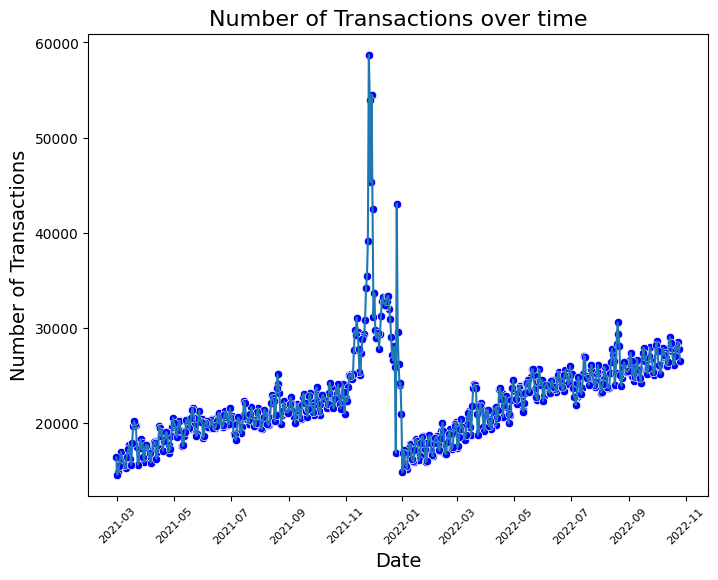

In [5]:
# Plotting the number of transaction per day.

transaction_date = transaction_data.groupBy('order_datetime') \
    .count().toPandas()

plt.figure(figsize= (8, 6))

sns.lineplot(x='order_datetime', y='count', data=transaction_date) 

sns.scatterplot(x='order_datetime', y='count', data=transaction_date, color='blue')

plt.xlabel ('Date' , fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.title('Number of Transactions over time', fontsize=16)

plt.xticks(rotation=45, fontsize=8)

plt.savefig('../plots/numbers_of_transaction_in_date.png', bbox_inches='tight')

plt.show()

Observations:

- evidence of annual trend

- there is a spike in the number of transactions from 2021/11~2022/1, which corresponds to the holiday season

In [6]:
# Divide the dataset into 5 groups based on their revenue level
data_names = ['a', 'b', 'c', 'd', 'e']
data_list = []
count_list = []
mean_list = []
for name in data_names:
    split_data = transaction_data.filter(col('merchant_revenue_lvl')==name)
    mean_list.append(float(split_data.select(split_data['dollar_value']).summary('mean').collect()[0][1]))
    data_list.append(split_data)
    count_list.append(split_data.count())

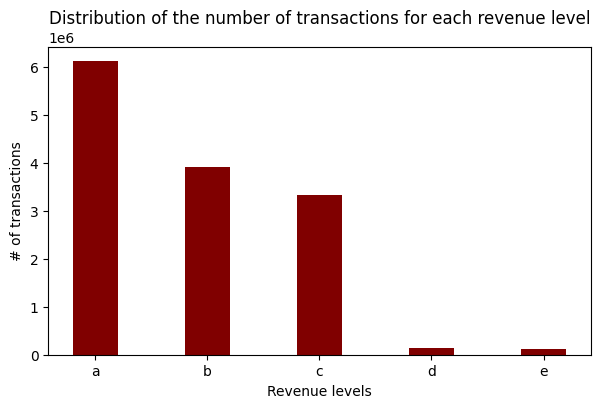

In [7]:
# Distribution of the number of transactions for each revenue level
fig = plt.figure(figsize = (7, 4))
plt.bar(data_names, count_list, color ='maroon',
        width = 0.4)
plt.xlabel("Revenue levels")
plt.ylabel("# of transactions")
plt.title("Distribution of the number of transactions for each revenue level")
plt.savefig('../plots/dist_transactions_rev_lvl.png')
plt.show()

Observation:
- Number of transactions by higher revenue level merchants are much smaller than those by lower revenue level merchants.

- high-revenue level merchants are not necessary making large number of transcations to generate those revenues

## 2. Merchant data

In [8]:
# prepare merchant data to analse
merchant = transaction_data\
    .groupBy('merchant_abn', 'merchant_desc', 'merchant_revenue_lvl', 'merchant_take_rate') \
    .agg(
        count('order_id').alias('num_transactions'),
        sum('dollar_value').alias('total_revenue'),
        mean('dollar_value').alias('average_revenue')
        ).withColumn('total_revenue', round(col('total_revenue'), 2))\
    .withColumn('average_revenue', round(col('average_revenue'), 2))

In [9]:
merchant_pd = merchant.toPandas()

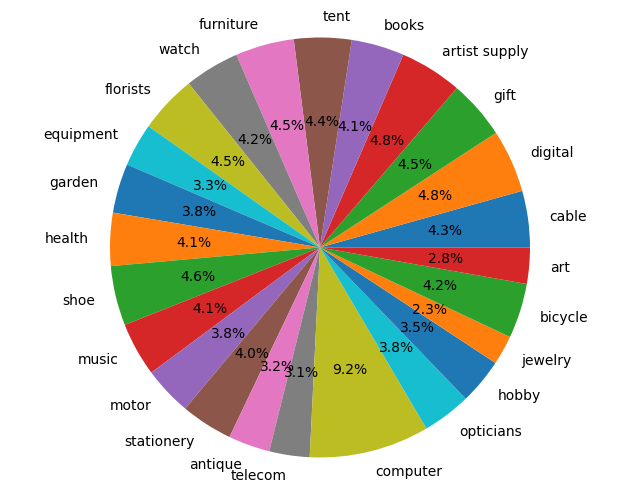

In [10]:
# plot proportion of each industry out of all the merchants as pie chart
desc = merchant_pd['merchant_desc'].unique()
tag = []
for i in desc:
    tag.append(len(merchant_pd.loc[merchant_pd['merchant_desc'] == i]))
plt.figure(figsize= (8, 6))
plt.pie(x=tag, labels=desc, autopct='%1.1f%%')
plt.axis('equal')

plt.savefig('../plots/merchant_tags_pie.png')
plt.show()

Observation:
- computer merchants are exceptionally high in proportion among all the merchants
- all the other industires are distributed quite evenly around 3~4%

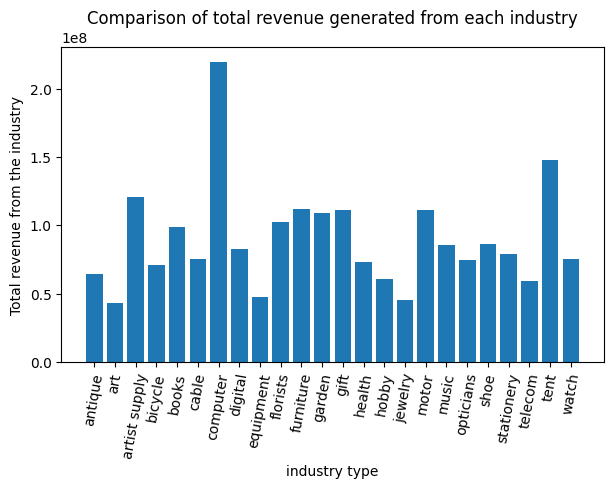

In [63]:
# plot the total revenue generated from each industry as bar chart
data = merchant_pd.groupby('merchant_desc')['total_revenue'].sum()
categories = data.index
values = data.values

plt.figure(figsize=(7, 5))
# Create the bar chart
plt.bar(categories, values)
# Add labels and title
plt.xticks(rotation=80)
plt.xlabel('industry type')
plt.ylabel('Total revenue from the industry')
plt.title('Comparison of total revenue generated from each industry')
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('../plots/revenue_IndustryComparison.png')
plt.show()

Observation:
- computer and tent industry is generating exceptionary high total revenue compared to other industry, meaning that a lot of money is being transferred in these two industries from consumers to the merchants

- potential benefit for the BNPL company to approach to these industries in specific

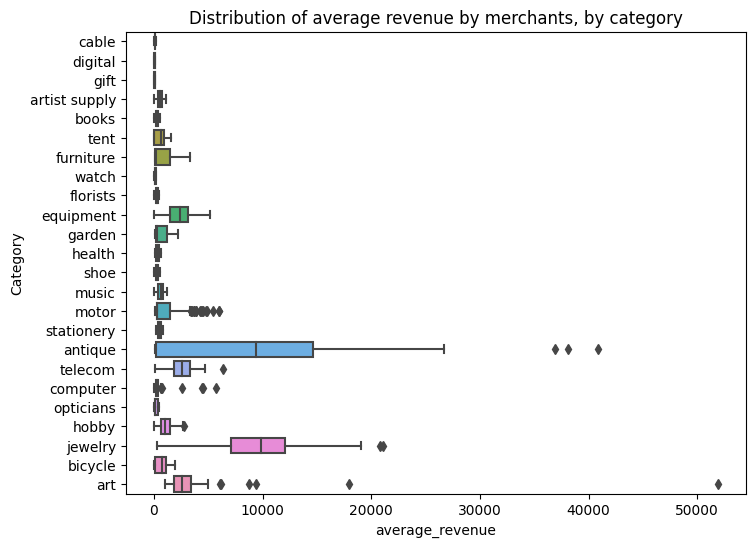

In [12]:
# plot the distribution of average revenue (average dollar amount gained from single transaction) by merchants in every industry
plt.figure(figsize=(8, 6)) 
sns.boxplot(x='average_revenue', y='merchant_desc', data=merchant_pd, orient='h')

plt.title('Distribution of average revenue by merchants, by category')
plt.xlabel('average_revenue')
plt.ylabel('Category')

plt.show()

Observation:
- antique and jewely industry having exceptionary high average revenue, meaning that single transaction can genearte high revenue compared to other industries

- merchants (and our BNPL company) have to be cautious that the transaction is credible and not fradulent, becuase single fraud can cause big loss to the company

## 3. Consumer data

In [13]:
# prepare consumer data to analyse
consumer = transaction_data\
    .groupBy('consumer_id', 'state', 'gender', 'postcode', 'SA2_CODE21', 'popDensity2022', 'num_earners', 'medianAge_earners', 'sum_income', 'median_income') \
    .agg(
        count('order_id').alias('num_transactions'),
        sum('dollar_value').alias('total_payment'),
        mean('dollar_value').alias('average_payment')
        ).withColumn('total_payment', round(col('total_payment'), 2))\
    .withColumn('average_payment', round(col('average_payment'), 2))

In [14]:
# number of effective consumers in every state
consumer.groupBy('state').count()

state,count
NT,343
ACT,221
SA,2736
TAS,893
WA,3812
QLD,3562
VIC,5566
NSW,6948


Observation:
- higher number of effective number of consumers (consumers who actually made transaction in the past) in NSW, which is followed by VIC and QLD.

In [15]:
# read in the SA2 shape file
sf = gpd.read_file("../data/landing/sa2_zones/SA2_2021_AUST_GDA2020.shp")
# set the 'geometry' feature
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf = sf.drop(2472)
sf.SA2_CODE21 = pd.to_numeric(sf["SA2_CODE21"])
geoJSON = sf[['SA2_CODE21', 'geometry']].drop_duplicates('SA2_CODE21').to_json()

23/10/20 01:04:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [16]:
num_consumer_SA2 = consumer.groupBy('SA2_CODE21').count()
num_consumer_SA2 = num_consumer_SA2.toPandas()
# SA2=122011418 at row 780 is identified to be outlier, make visualization without this outlier
num_consumer_SA2 = num_consumer_SA2.drop(780)

In [17]:
num_consumer_SA2['count'].describe()

count    1403.000000
mean       16.403421
std        16.781036
min         1.000000
25%         7.000000
50%        10.000000
75%        19.000000
max       149.000000
Name: count, dtype: float64

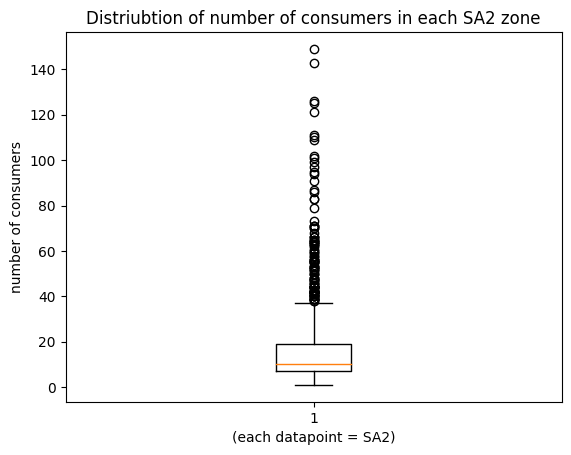

In [18]:
# plot the distribution of number fo consumers in each SA2 zone, without the outlier of SA2 = 122011418
data = num_consumer_SA2['count']

plt.boxplot(data)
plt.ylabel('number of consumers')
plt.xlabel('(each datapoint = SA2)')
plt.title('Distriubtion of number of consumers in each SA2 zone')
plt.show()

Observation:
- average number of consumers in each SA2 zone lies around 10

- InterQuatile range from 7 to 19, but there are many outliers goes above 40 which corresponds to populated, urban areas

### Geoaptial visualization

i) number of consumers in every SA2 zone

In [19]:
# map the number of consumers in every SA2 zone
_map = folium.Map(location=[-25.2744, 133.7751],tiles="Stamen Terrain", zoom_start=4.4)

post_shape = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth', 
    data=num_consumer_SA2.reset_index(),
    columns=['SA2_CODE21','count'],
    key_on='properties.SA2_CODE21', 
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Number of consumers in each SA2'
)

post_shape.add_to(_map)
_map.save('../plots/num_consumers.html')
# _map

ii) average payment made by each consumer in every SA2 zone

(how much money did people in particular SA2 pay throughout the period, in average)

In [20]:
averagePayment_SA2 = consumer.groupBy('SA2_CODE21')\
    .agg(mean("total_payment").alias('average_payment'))
averagePayment_SA2 = averagePayment_SA2.toPandas()

In [21]:
# map the average of total payment made by each consumer in every SA2 zone
_map = folium.Map(location=[-25.2744, 133.7751],tiles="Stamen Terrain", zoom_start=4.4)

post_shape = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth', 
    data=averagePayment_SA2.reset_index(),
    columns=['SA2_CODE21','average_payment'],
    key_on='properties.SA2_CODE21', 
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='Average payment'
)

post_shape.add_to(_map)
_map.save('../plots/payment_average.html')
# _map

## 4. Fraud data

### i) consumer fraud data

In [22]:
# read in data
consumer_details = spark.read.format("csv")\
                   .options(header=True, delimiter="|")\
                   .load('../data/tables/tbl_consumer.csv')
consumer_fraud = spark.read.format("csv")\
                 .options(header=True, delimiter=",")\
                 .load('../data/tables/consumer_fraud_probability.csv')
consumer_user = spark.read.parquet("../data/tables/consumer_user_details.parquet")

In [23]:
# prepare consumer fraud data to analyse
consumer_details = consumer_details.join(consumer_user, "consumer_id", "left")
consumer_fraud = consumer_fraud.join(consumer_details, "user_id", "left")
consumer_fraud = consumer_fraud.toPandas()
consumer_fraud["fraud_probability"] = pd.to_numeric(consumer_fraud["fraud_probability"])

# set a threshold of probability > 0  to regard the transaction as suspicious
consumer_fraud = consumer_fraud[consumer_fraud["fraud_probability"] > 50]

In [24]:
# number of suspcious transaction made by each gender
consumer_fraud["gender"].value_counts()

Male           314
Female         294
Undisclosed     87
Name: gender, dtype: int64

In [25]:
# number of suspcious transaction made by each state
consumer_fraud["state"].value_counts()

NSW    205
VIC    164
QLD    111
WA      86
SA      83
TAS     33
NT      11
ACT      2
Name: state, dtype: int64

In [26]:
# number of consumer fraudulent transactions at each postcode
# key = number of fraudulent trasactions
# value = number of postcode with the corresponding number of fradulent transactions
dict(sorted(Counter(list(consumer_fraud["postcode"].value_counts())).items(), key = lambda i: i[0]))

{1: 411, 2: 105, 3: 17, 4: 3, 5: 1, 6: 1}

Text(0, 0.5, 'Number of postcodes')

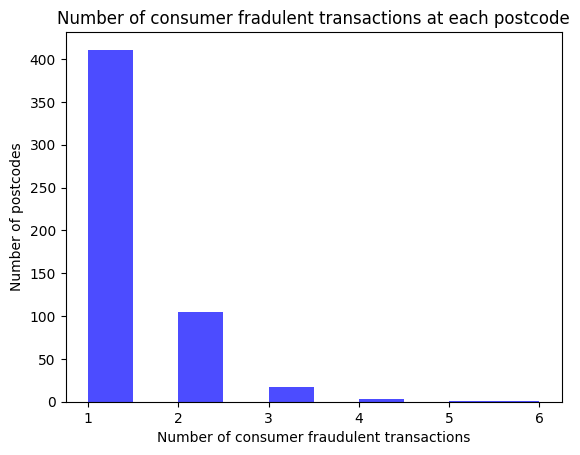

In [27]:
# visualize the above data as bar chart
data = consumer_fraud["postcode"].value_counts()
plt.hist(data, color='blue', alpha=0.7)
plt.title('Number of consumer fradulent transactions at each postcode')
plt.xlabel('Number of consumer fraudulent transactions')
plt.ylabel('Number of postcodes')

Observation:

- Most of the postcodes are having single history of consumer fraudulent transaction, while there are few postcodes with higher number of consumer fraud histories

- those postcodes need special attention later

### ii) merchant frauad data

In [28]:
merchant_fraud = spark.read.format("csv")\
                 .options(header=True, delimiter=",")\
                 .load('../data/tables/merchant_fraud_probability.csv')
merchant_fraud = merchant_fraud.join(merchant, "merchant_abn", "left")
merchant_fraud = merchant_fraud.toPandas()
merchant_fraud ["fraud_probability"] = pd.to_numeric(merchant_fraud ["fraud_probability"])
merchant_fraud  = merchant_fraud [merchant_fraud ["fraud_probability"] > 20]

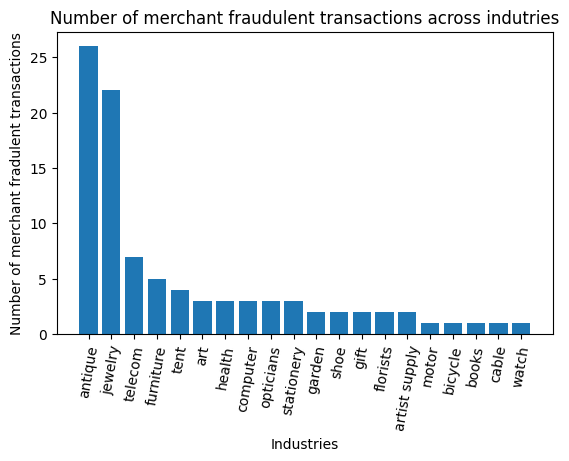

In [65]:
data = merchant_fraud["merchant_desc"].value_counts()
categories = data.index
values = data.values

# Create the bar chart
plt.bar(categories, values)

# Add labels and title
plt.xticks(rotation=80)
plt.xlabel('Industries')
plt.ylabel('Number of merchant fradulent transactions')
plt.title('Number of merchant fraudulent transactions across indutries')
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('../plots/merchantFraud_IndustryComparison.png')
plt.show()

Observation:

- antique and jewely are the top two industries with merchant fraudulent transactions

- the two industries are both in luxury segments with high average revenue per transaction, therefore single fraud can cause big benefit to the cheater, big loss to the other side.